In [2]:
import cv2
import numpy as np
from utils import *
from segmentation import *

In [2]:
def imageToWords(img):
    words = []
    lines = breakLines(img)
    for line in lines:
        line_words = breakWords(line)
        line_words.reverse()
        for word in line_words:
            words.append(word)
            
    return words

In [3]:
letter_counts = {
    "ا" : 0,
    "ب" : 0,
    "ت" : 0,
    "ث" : 0,
    "ج" : 0,
    "ح" : 0,
    "خ" : 0,
    "د" : 0,
    "ذ" : 0,
    "ر" : 0,
    "ز" : 0,
    "ش" : 0,
    "س" : 0,
    "ص" : 0,
    "ض" : 0,
    "ط" : 0,
    "ظ" : 0,
    "ع" : 0,
    "غ" : 0,
    "ف" : 0,
    "ق" : 0,
    "ك" : 0,
    "ل" : 0,
    "م" : 0,
    "ن" : 0,
    "ه" : 0,
    "و" : 0,
    "ي" : 0,
    "ﻻ" : 0,
    "ى" : 0,
    "ئ" : 0,
    "ء" : 0,
    "ؤ" : 0,
    "ة" : 0
}

In [5]:
def imgToDataSet(img_path, text_path):
    img = cv2.imread(img_path)
    img_words = imageToWords(img)
    with open(text_path) as f:
        text = f.readlines()[0]
        text_words = text.split()
        index = 0
        for word in text_words:
            if index >= len(img_words):
                break
            chars = segmenteCharacters(img_words[index])
            if len(chars) == len(word):
                chars.reverse()
                for i in range(len(word)):
                    letter = 255*extractTemplate(chars[i])
                    if letter.shape[0] < 25 and letter.shape[1] < 25:
                        mask = np.zeros((25, 25))

                        vertical_start = int((25 - letter.shape[0]) / 2)
                        vertical_end = vertical_start + letter.shape[0]
                        horizontal_start = int((25 - letter.shape[1]) / 2)
                        horizontal_end = horizontal_start + letter.shape[1]

                        mask[vertical_start:vertical_end, horizontal_start:horizontal_end] = letter
                        cv2.imwrite("./DataSets/dataSet/" + word[i] + "/" + word[i] + "_" + str(letter_counts[word[i]]) + ".png", mask)
                        letter_counts[word[i]] += 1
            index += 1

In [15]:
count = 10
img_path = "./DataSets/sample/test" + str(count) + "/test" + str(count) + ".png"
text_path = "./DataSets/sample/test" + str(count) + "/test" + str(count) + ".txt"
imgToDataSet(img_path, text_path)

In [3]:
img_path = "./DataSets/sample/test10/test10.png"
img = cv2.imread(img_path)
lines = breakLines(img)
words = breakWords(lines[0])

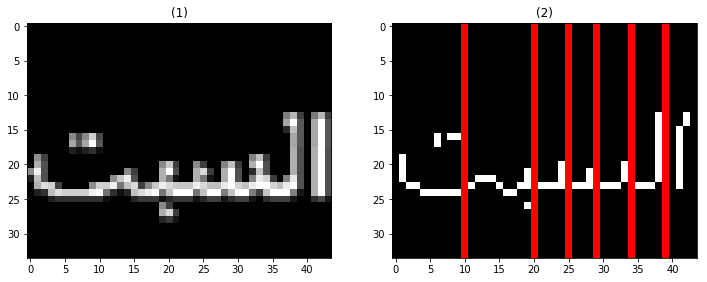

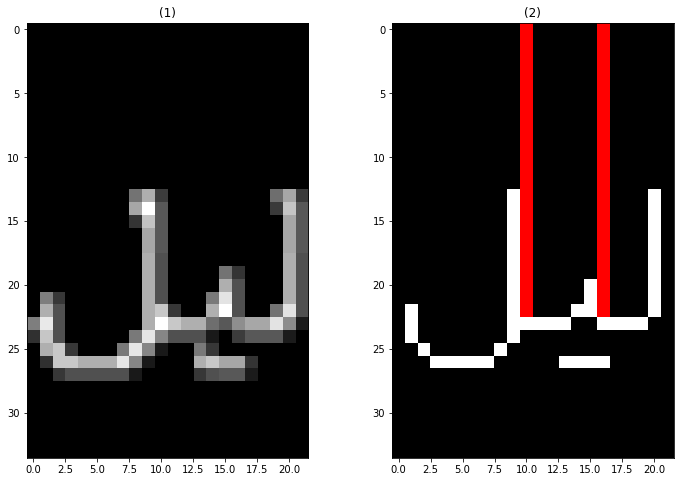

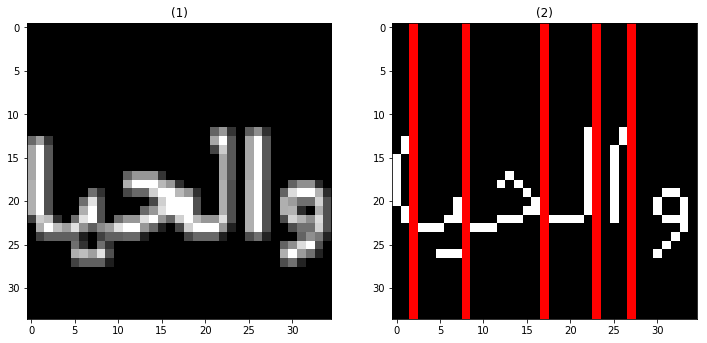

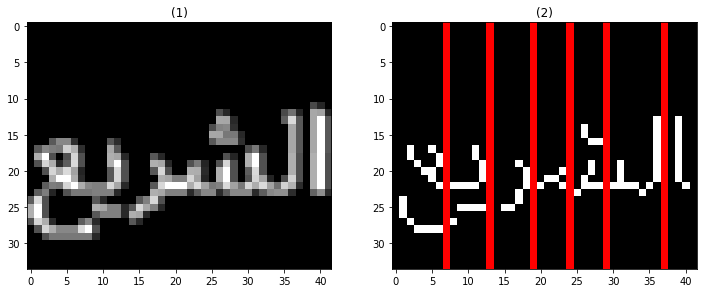

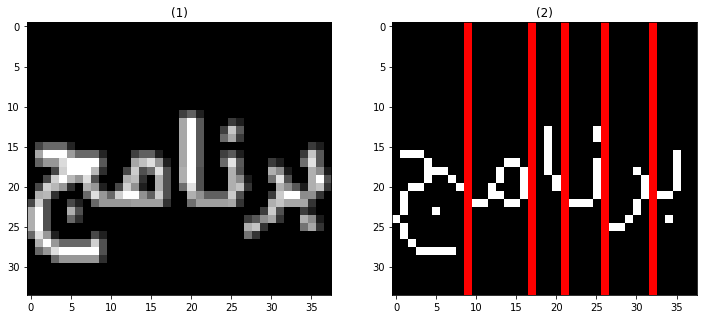

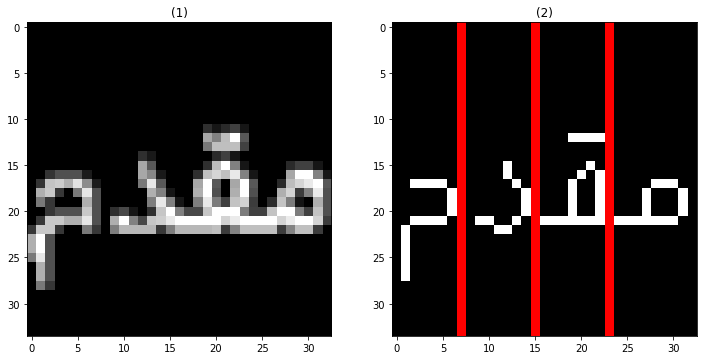

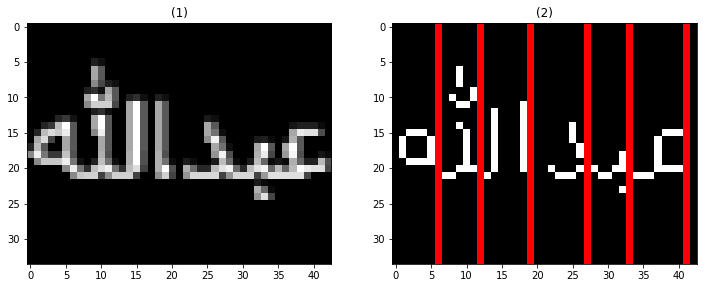

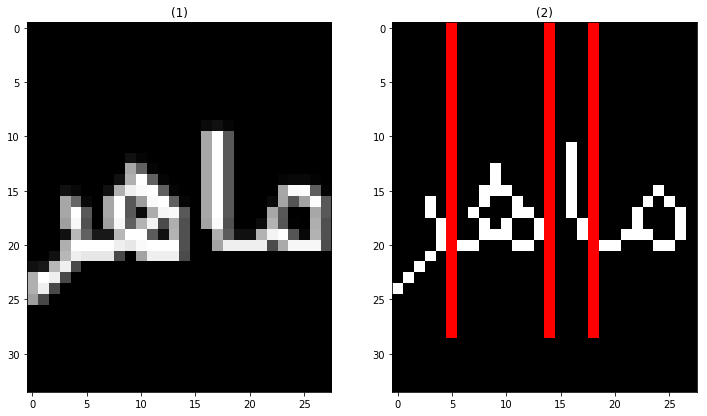

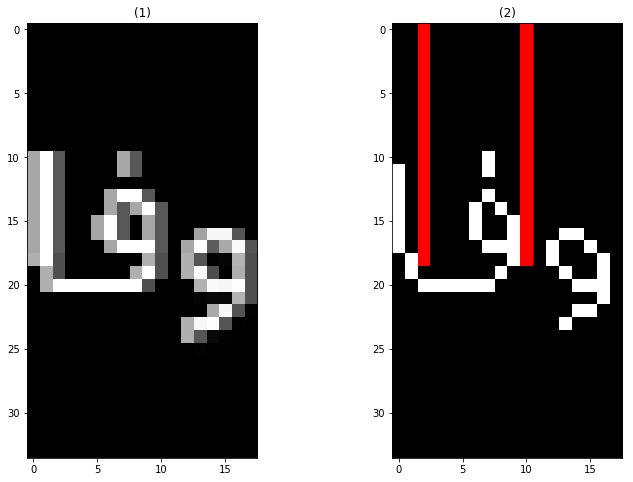

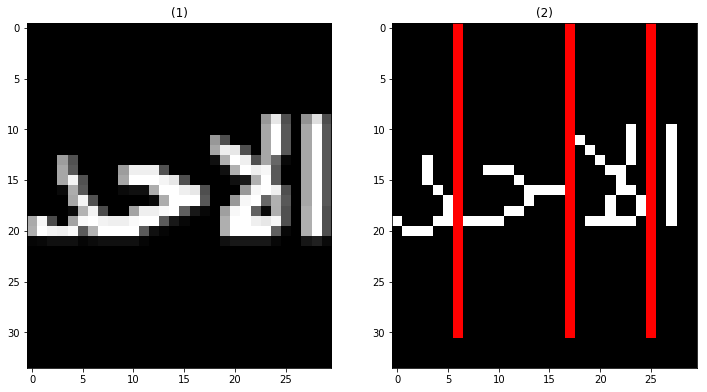

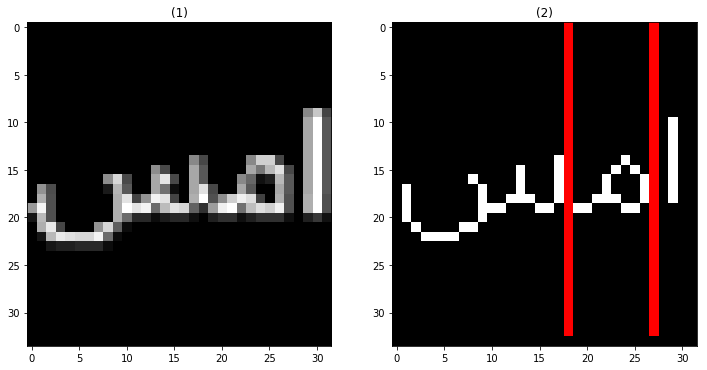

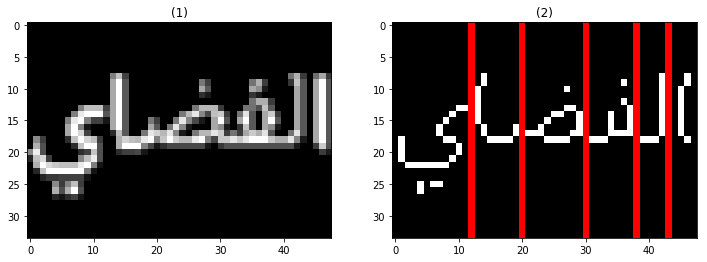

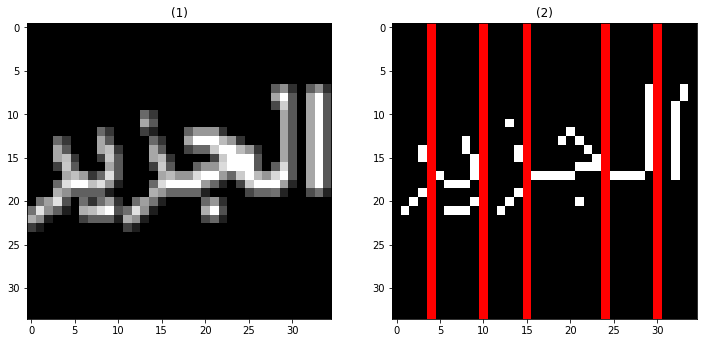

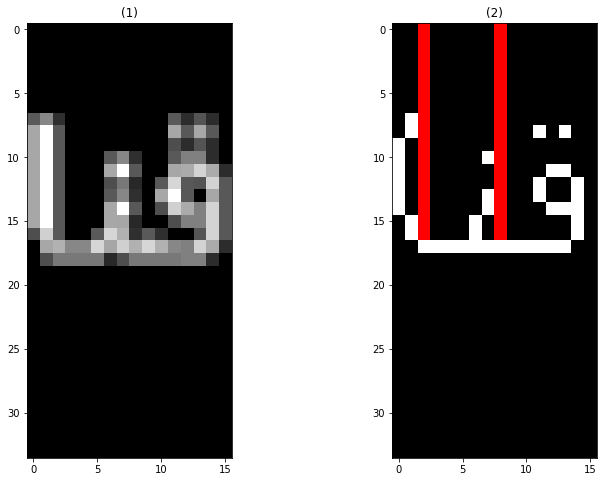

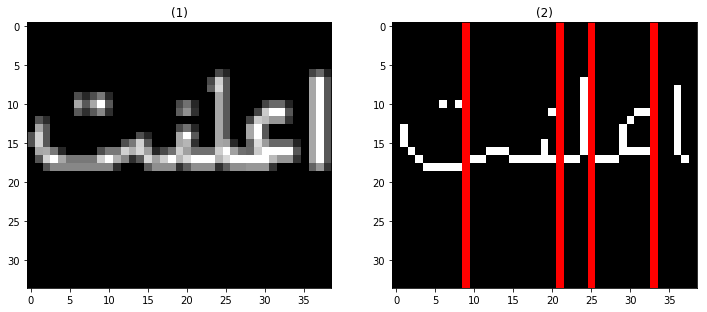

AttributeError: 'list' object has no attribute 'ndim'

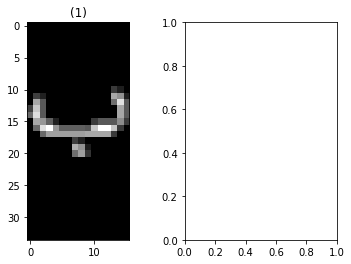

In [5]:
for word in words:
    show_images([word, segmenteCharacters(word, debug=True)])